<a href="https://colab.research.google.com/github/arnaldojr/PLD-UAV/blob/master/vgg_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# TRANSFERENCIA DE CONHECIMENTO E SEGMENTAÇÃO
# Uso a rede treinada VGG16 treinada com dataset imagenet
# pego os pesos das camadas de convolução e max pooling
# tiro output layer da rede 
# e adiciono meu o meu classificador randon forest de 1 classe


import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import glob
import cv2
import pickle

from keras.models import Sequential, Model
from keras.layers import Conv2D
import os
from keras.applications.vgg16 import VGG16

#from google.colab.patches import cv2_imshow


In [2]:
!git clone https://github.com/arnaldojr/PLD-UAV.git

Cloning into 'PLD-UAV'...
^C


In [3]:
# Read input images and assign labels based on folder names
print(os.listdir("vgg_segmentation"))

['Train_mask', 'Train_images']


In [4]:
#Resizing images is optional, CNNs are ok with large images
SIZE_X = 224 #Resize images (height  = X, width = Y)
SIZE_Y = 224


In [5]:
#Capture training image info as a list
train_images = []

for directory_path in glob.glob("vgg_segmentation/Train_images/"):
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)       
        img = cv2.resize(img, (SIZE_Y, SIZE_X))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        train_images.append(img)
        #train_labels.append(label)
#Convert list to array for machine learning processing        
train_images = np.array(train_images)
print(train_images.shape)
#cv2_imshow(train_images[0])

(120, 224, 224, 3)


In [6]:
#Capture mask/label info as a list
train_masks = [] 
for directory_path in glob.glob("vgg_segmentation/Train_mask/"):
    for mask_path in glob.glob(os.path.join(directory_path, "*.png")):
        mask = cv2.imread(mask_path, 0)       
        mask = cv2.resize(mask, (SIZE_Y, SIZE_X))
        #mask = cv2.cvtColor(mask, cv2.COLOR_RGB2BGR)
        train_masks.append(mask)
        #train_labels.append(label)
#Convert list to array for machine learning processing          
train_masks = np.array(train_masks)
print(train_masks.shape)
#cv2_imshow(train_masks[0])

(120, 224, 224)


In [7]:
#Use customary x_train and y_train variables
X_train = train_images
y_train = train_masks
y_train = np.expand_dims(y_train, axis=3) #May not be necessary.. leftover from previous code 

In [8]:
#Load VGG16 model wothout classifier/fully connected layers
#Load imagenet weights that we are going to use as feature generators
VGG_model = VGG16(weights='imagenet', include_top=False, input_shape=(SIZE_X, SIZE_Y, 3))
    
VGG_model.summary()  #Trainable parameters is 14,714,688 yet will be 0

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [9]:
#Make loaded layers as non-trainable. This is important as we want to work with pre-trained weights
for layer in VGG_model.layers:
	layer.trainable = False
    
VGG_model.summary()  #Trainable parameters will be 0

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [10]:
#After the first 2 convolutional layers the image dimension changes. 
#So for easy comparison to Y (labels) let us only take first 2 conv layers
#and create a new model to extract features
#New model with only first 2 conv layers
new_model = Model(inputs=VGG_model.input, outputs=VGG_model.get_layer('block1_conv2').output)
new_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
Total params: 38,720
Trainable params: 0
Non-trainable params: 38,720
_________________________________________________________________


In [11]:
print(X_train.shape)

(120, 224, 224, 3)


In [12]:
#Now, let us apply feature extractor to our training data
features=new_model.predict(X_train)

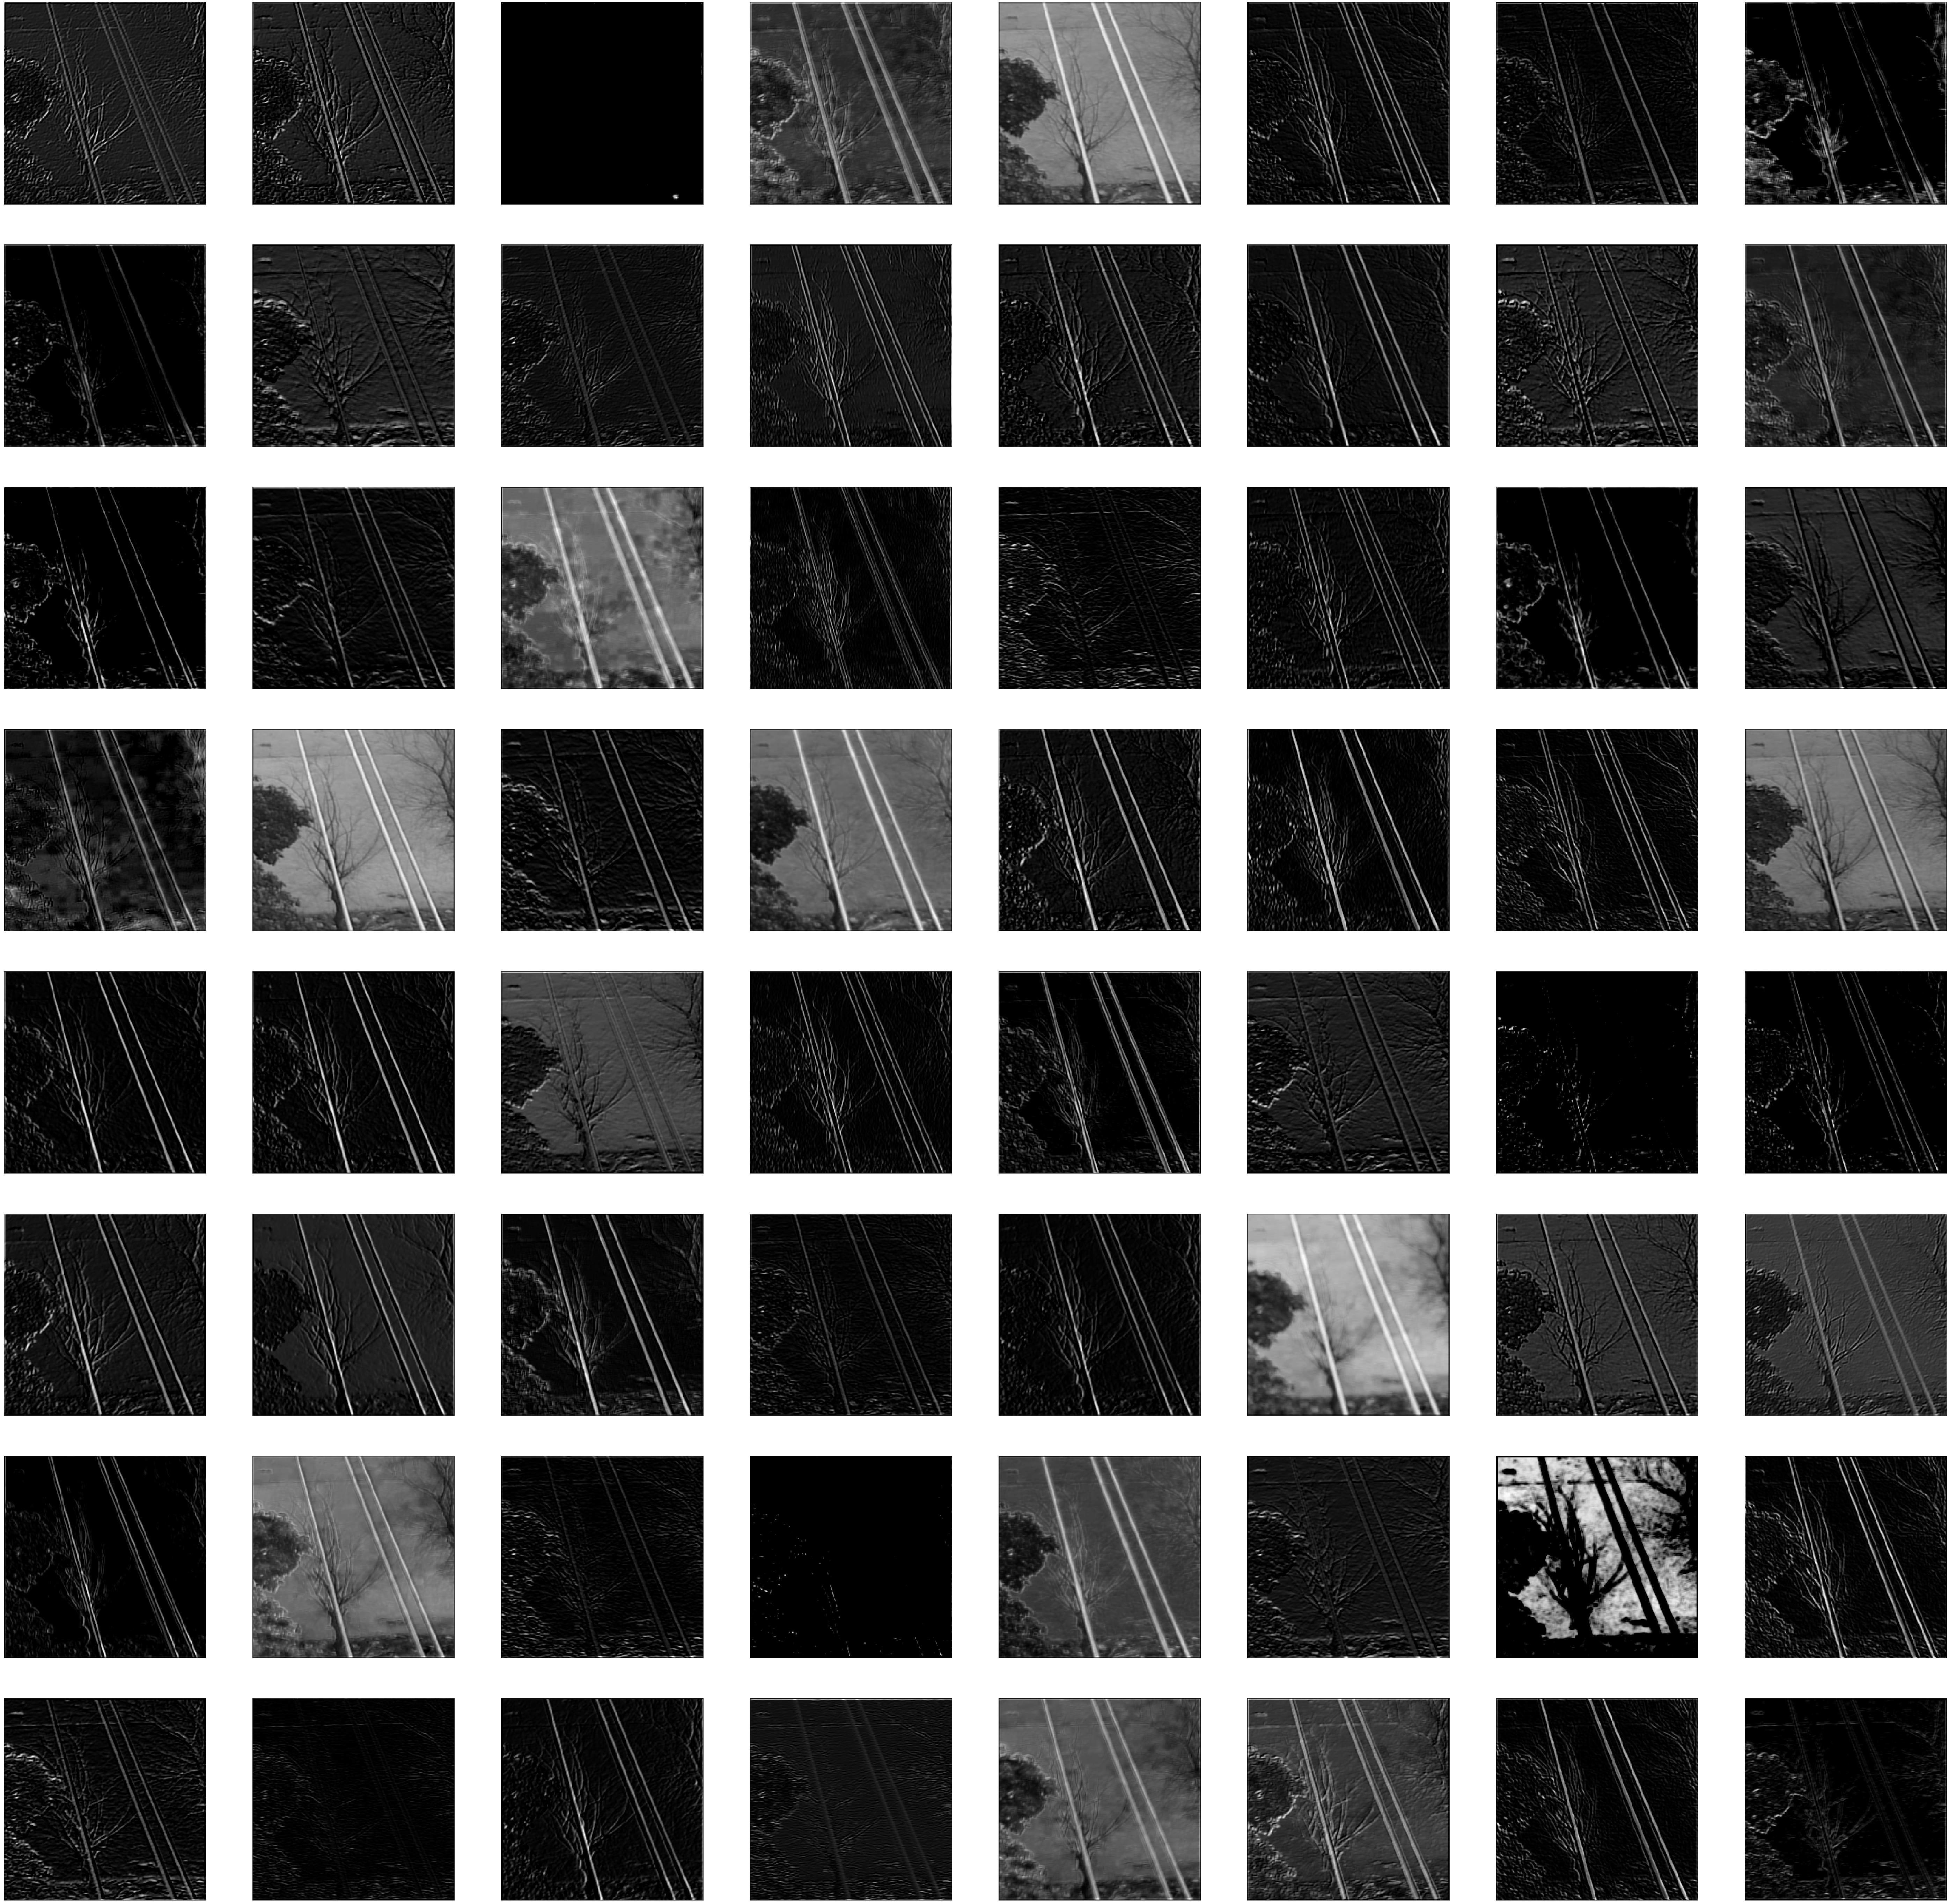

In [32]:
#Plot features to view them
square = 8
ix=1
plt.figure(figsize=(100, 100))
for _ in range(square):
    for _ in range(square):
        ax = plt.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(features[0,:,:,ix-1], cmap='gray')
        ix +=1
plt.show()

In [30]:
#Reassign 'features' as X to make it easy to follow
X=features
X = X.reshape(-1, X.shape[3])  #Make it compatible for Random Forest and match Y labels

#Reshape Y to match X
Y = y_train.reshape(-1)
print(Y.shape)

(6021120,)


In [15]:
#Combine X and Y into a dataframe to make it easy to drop all rows with Y values 0
#In our labels Y values 0 = unlabeled pixels. 
dataset = pd.DataFrame(X)
dataset['Label'] = Y
print(dataset['Label'].unique())
print(dataset['Label'].value_counts())


[255 235 248 239 204 252 244 233 156 249 234 211  79 254 240 205  94  11
 251 209  85   9   4 222 104  10  17 224 117  16  26  29 129  19  20  41
 241 207 121  24   5  43 203   6  47   3 216 115  68 108 201  23  44  18
  21 102 186 225  27  70  22 134 184 120  72  25 113 212 236 200  93  57
  87 188 227 127 194 220 230 232 217 167  42  36   8  64 172 231  39   7
  75 168 219 138 176  63  59 166 215 226 208 171  52 242 161  45  66  13
 157 237 169  62 173  53 189 238 245 243  81  14  54  58  15 179 228  12
 158  34  37  91 197 193 103  73 198 123  30  48  50 246 210 146  28 185
  69 199 218 162  56  83  74  60 182 116  32 202 178 118  40 124  55 247
  38  51  90 196  61 187  46  65 214  76 206  71 183 223 165  88 253 175
 140  92 170 111  35  96  95 221 128 229  67 150 159 177 250 164  80  49
 190  31 153 126 144 119 130 149 160 141 180 163 139 112 192  77  82  33
  84 195 213  89 151  86 154 109 148 181 132  99 122 105 114  98 107  78
 142 145 106 155 125 135 131 100 143 101  97 191 13

In [16]:
dataset.items

<bound method DataFrame.items of                    0           1    2           3           4           5  \
0        1138.706055   86.328362  0.0  238.816956  499.718323    0.000000   
1         423.642426  145.254013  0.0  325.131195  968.519409    0.000000   
2         365.039978  150.994461  0.0  298.404907  949.624390  337.813904   
3         301.701447  127.810226  0.0  293.090820  948.538574  363.332886   
4         301.796509  119.808891  0.0  290.485382  935.875427  365.189209   
...              ...         ...  ...         ...         ...         ...   
6021115     0.000000    0.000000  0.0   48.087723  429.656891    0.000000   
6021116     0.000000    0.000000  0.0   47.290817  431.243866    0.000000   
6021117     0.000000    0.000000  0.0   48.807117  427.987640    0.000000   
6021118     0.000000    0.000000  0.0   88.435196  353.916473    0.000000   
6021119   261.479309    0.000000  0.0   12.202381  298.009796    0.000000   

                  6           7           

In [17]:
##If we do not want to include pixels with value 0 
##e.g. Sometimes unlabeled pixels may be given a value 0.
dataset = dataset[dataset['Label'] != 0]


In [18]:
#Redefine X and Y for Random Forest
X_for_RF = dataset.drop(labels = ['Label'], axis=1)
Y_for_RF = dataset['Label']
print(X_for_RF)


                  0           1    2           3           4           5   \
0        1138.706055   86.328362  0.0  238.816956  499.718323    0.000000   
1         423.642426  145.254013  0.0  325.131195  968.519409    0.000000   
2         365.039978  150.994461  0.0  298.404907  949.624390  337.813904   
3         301.701447  127.810226  0.0  293.090820  948.538574  363.332886   
4         301.796509  119.808891  0.0  290.485382  935.875427  365.189209   
...              ...         ...  ...         ...         ...         ...   
6021115     0.000000    0.000000  0.0   48.087723  429.656891    0.000000   
6021116     0.000000    0.000000  0.0   47.290817  431.243866    0.000000   
6021117     0.000000    0.000000  0.0   48.807117  427.987640    0.000000   
6021118     0.000000    0.000000  0.0   88.435196  353.916473    0.000000   
6021119   261.479309    0.000000  0.0   12.202381  298.009796    0.000000   

                 6           7           8           9   ...   54          

In [19]:
print(Y_for_RF)

0          255
1          255
2          255
3          255
4          255
          ... 
6021115    255
6021116    255
6021117    255
6021118    255
6021119    255
Name: Label, Length: 6021069, dtype: uint8


In [26]:
#RANDOM FOREST
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators = 50, random_state = 42, max_depth=6)

In [ ]:
# Train the model on training data
model.fit(X_for_RF, Y_for_RF) 

In [27]:
#aind nao testei essa parte





#Save model for future use
filename = 'RF_model.sav'
pickle.dump(model, open(filename, 'wb'))

#Load model.... 
loaded_model = pickle.load(open(filename, 'rb'))

#Test on a different image
#READ EXTERNAL IMAGE...
test_img = cv2.imread('PLD-UAV/PLDM/test/104.jpg', cv2.IMREAD_COLOR)       
test_img = cv2.resize(test_img, (SIZE_Y, SIZE_X))
test_img = cv2.cvtColor(test_img, cv2.COLOR_RGB2BGR)
test_img = np.expand_dims(test_img, axis=0)

#predict_image = np.expand_dims(X_train[8,:,:,:], axis=0)
X_test_feature = new_model.predict(test_img)
X_test_feature = X_test_feature.reshape(-1, X_test_feature.shape[3])

prediction = loaded_model.predict(X_test_feature)

#View and Save segmented image
prediction_image = prediction.reshape(mask.shape)
plt.imshow(prediction_image, cmap='gray')
plt.imsave('/content/PLD-UAV/PLDU/104_resultado.jpg', prediction_image, cmap='gray')

[255 228 218 239 254 190 224 231 229 234 236 237 131 164 177 189 186 179
 178 194 200 202 205 207 213 222 240 248 249 250 247 251  48  58  67  86
  91  92  97 105 110 121 127 129 132 134 143 158 170 181 188 192 196 198
 197 191 185 176 172 182 203 206 212 208 214 216 215 221 219 223 227 233
 232 238  14  11  13  16  18  21  22  24  23  25  33  35  37  46  55  60
  63  65  68  66  64  61  59  62  69  74  82  90  96  98 102 112 124 130
 128 137 144 142 147 156 160 174 183 184 187 204 201 210 225 226 242 243
 244  40  26  20  19  15  12  10   9   8  29  31  36  43  52  73  75  79
  95 116 122 126 141 167 171 168 193 217 230 253 145 118 103  88  81  76
  77  71  56  51  49  42  38  34  28  27  17  50  54  78 108 120 125 123
 140 195 211 180 166 159 153 146 111 100  53  47  45  30  41  72  80  70
  87 117 114 139 148 155 169 245 246 173 149 161 162 165 136 150 152 106
  99  93  94  39  32  57 104 113 133 175 199 209 220 107 157 154 163 119
 115  83 138 109 101  84  44   7 151  85 135  89 23

KeyboardInterrupt: ignored